## **Análise de Funil de Eventos e Teste A/A/B**  
### **Event Funnel Analysis and A/A/B Testing**

**Clara Álvares Camargo**  
Setembro/2024

## 0.Bibliotecas

In [640]:
# importando bibliotecas

import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
import numpy as np

## 1.Leitura dos dados

### 1.0.Carregamento os dados

In [641]:
# carregando os dados

logs_br = pd.read_csv('./logs_exp_us.csv',sep='\t')

### 1.1.Visualização os dados

In [642]:
# visualizando os dados
logs_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [643]:
# visualizando os dados
logs_br.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [644]:
# visualizando os dados
logs_br.sample(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
103146,CartScreenAppear,2286563893048866304,1564855116,247
25852,MainScreenAppear,1144951999511701317,1564672194,247
48017,MainScreenAppear,143053681101464831,1564734737,248
8803,MainScreenAppear,1541400765883090864,1564645451,248
3083,MainScreenAppear,6928114357124159164,1564622312,246


In [645]:
# visualizando os dados
logs_br.tail()

,EventName,DeviceIDHash,EventTimestamp,ExpId
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246
244125,OffersScreenAppear,5746969938801999050,1565212517,246


### 1.2.Tratamento dos dados

In [646]:
# renomeando colunas
logs_br = logs_br.rename(columns={'EventName': 'event', 'DeviceIDHash': 'user_id', 'EventTimestamp':'datetime', 'ExpId':'group'})

In [647]:
#conferindo DataFrame
logs_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   event     244126 non-null  object
 1   user_id   244126 non-null  int64 
 2   datetime  244126 non-null  int64 
 3   group     244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [648]:
# conferindo se há valores ausentes
logs_br.isnull().sum()

event       0
user_id     0
datetime    0
group       0
dtype: int64

In [649]:
# conferindo se há linhas duplicadas
logs_br.duplicated().sum()

413

In [650]:
# deletando linhas duplicadas
logs_br.drop_duplicates(inplace=True)

In [651]:
# conferindo DataFrame
logs_br.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   event     243713 non-null  object
 1   user_id   243713 non-null  int64 
 2   datetime  243713 non-null  int64 
 3   group     243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


In [652]:
# convertendo coluna 'datetime' para formato datetime
logs_br['date_time'] = pd.to_datetime(logs_br['datetime'], unit='s')

# extraindo apenas a data
logs_br['date'] = logs_br['date_time'].dt.date

# excluindo coluna timestamp
logs_br = logs_br.drop(['datetime'], axis=1)

#### 1.2.1.Anotações

O DataFrame não possui valores ausentes, mas foram identificadas 411 linhas de dados duplicados.  
Os dados duplicados foram deletados e o tipo de dado da coluna 'datetime' foi ajustado.

### 1.3.Visualização dos dados

In [653]:
# visualizando DataFrame após tratamento dos dados
logs_br.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   user_id    243713 non-null  int64         
 2   group      243713 non-null  int64         
 3   date_time  243713 non-null  datetime64[ns]
 4   date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [654]:
# visualizando DataFrame após tratamento dos dados
logs_br.head()

,event,user_id,group,date_time,date
0,MainScreenAppear,4575588528974610257,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,248,2019-07-25 11:48:42,2019-07-25


## 2.Verificação dos dados

### **2.1.Eventos**

#### 2.1.1.Processamento

In [655]:
# contando número de eventos registrados
logs_br['event'].count()

243713

In [656]:
# listando valores unívocos da coluna 'event'
logs_br['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

#### 2.1.2.Anotações

**Eventos:**    
  
Número total de eventos: 243713  
  
Eventos unívocos:  
Main Screen Appear  
Payment Screen Successful  
Cart Screen Appear  
Offers Screen Appear     
Tutorial   

### **2.2.Usuários**

#### 2.2.1.Processamento

In [657]:
# listando quantidade de valores unívocos da coluna 'id'
logs_br['user_id'].nunique()

7551

#### 2.2.2.Anotações

**Usuários:** 
 
7551 usuários unívocos

### **2.3.Número médio de eventos por usuário**

#### 2.3.1.Processamento

In [658]:
# calculando quantidade de eventos por usuário
events_by_user_br = (
    logs_br.drop(['group', 'date_time', 'date'], axis=1)
    .groupby('user_id', as_index=False)
    .agg({'event': pd.Series.count})
)

events_by_user_br.columns = ['user_id', 'events']

print(events_by_user_br.sort_values(by='user_id', ascending=False).head(10))

                  user_id  events
7550  9222603179720523844      59
7549  9221926045299980007       7
7548  9220879493065341500       7
7547  9219463515465815368      17
7546  9217594193087726423       9
7545  9216369613838971606      24
7544  9216094175241772920       2
7543  9215717049765076788      10
7542  9214668690707156694      36
7541  9212961170535635779      46


In [659]:
# calculando média de eventos por usuário
events_by_user_br['events'].mean()

32.27559263673685

In [660]:
# visualizando distribuição dos dados
events_by_user_br['events'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: events, dtype: float64

Text(0, 0.5, 'events')

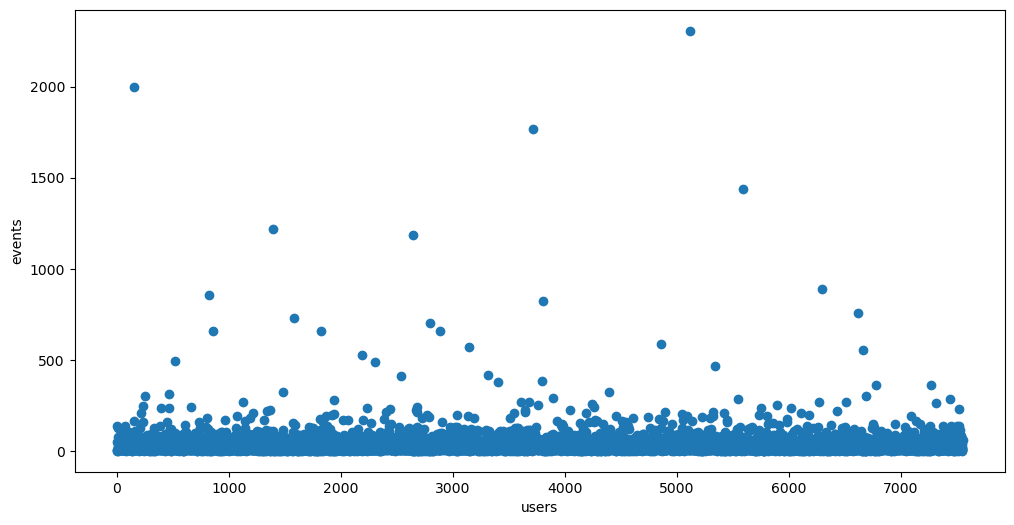

In [661]:
# visualizando distribuição dos dados
# gráfico de dispersão
x_values = pd.Series(range(0,len(events_by_user_br)))

plt.figure(figsize=(12, 6))
plt.scatter(x_values, events_by_user_br['events'])
plt.xlabel('users')
plt.ylabel('events')

In [662]:
# visualizando percentis
print(np.percentile(events_by_user_br['events'], [90, 95, 99]))

[ 64.   89.  200.5]


In [663]:
# definindo usuários com valores atípicos
users_with_many_events = pd.concat([events_by_user_br[events_by_user_br['events'] > 201]['user_id']])

In [664]:
# filtrando o DataFrame removendo usuários com valores atípicos
logs_filtered = logs_br[~logs_br['user_id'].isin(users_with_many_events)]

In [665]:
# calculando quantidade de eventos por usuário após filtragem
events_by_user = (
    logs_filtered.drop(['group', 'date_time', 'date'], axis=1)
    .groupby('user_id', as_index=False)
    .agg({'event': pd.Series.count})
)

events_by_user.columns = ['user_id', 'events']

In [666]:
# calculando média de eventos por usuário após filtragem
events_by_user['events'].mean()

28.004414715719065

#### 2.3.1.Anotações

Menos de 5% dos usuários realizaram mais que 88 ações, e menos de 1% realizaram mais que 201.  
O DataFrame foi filtrado para excluir os usuários com número de eventos superior a 201.

### **2.4.Intervalo de tempo**

#### 2.4.1.Processamento

In [667]:
# verificando período de tempo dos dados
logs_filtered['date_time'].describe()

count                           209333
mean     2019-08-04 10:45:16.095952640
min                2019-07-25 04:43:36
25%                2019-08-02 14:49:48
50%                2019-08-04 12:20:54
75%                2019-08-06 07:59:59
max                2019-08-07 21:15:17
Name: date_time, dtype: object

#### 2.4.2.Anotações

**Intervalo de tempo dos dados brutos:**  

De 25/07/2019 a 07/08/2019.

#### 2.4.3.Histograma

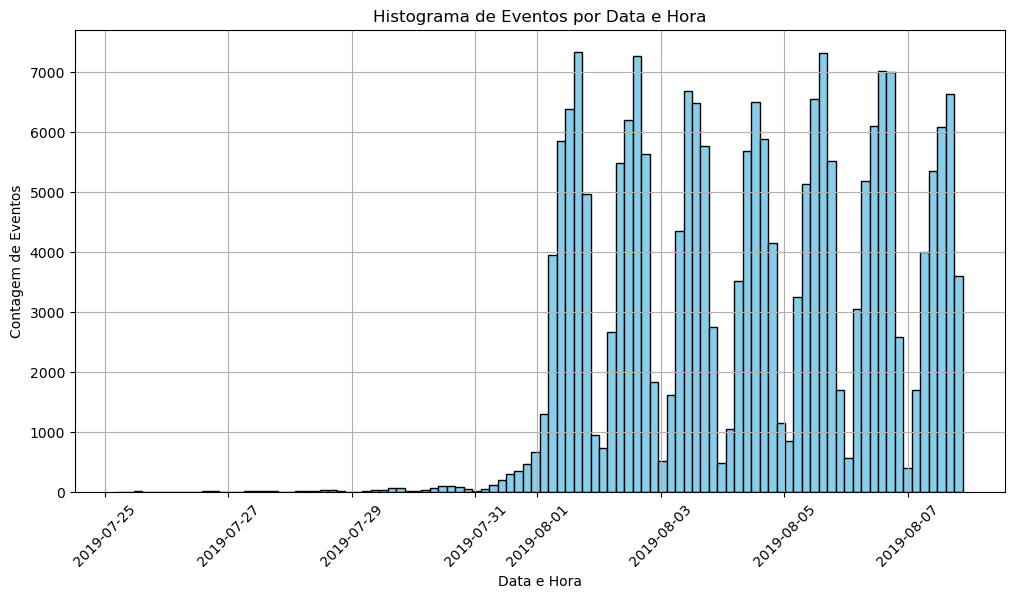

In [668]:
# imprimindo histograma de eventos por data/hora
plt.figure(figsize=(12, 6))
logs_filtered['date_time'].hist(bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Data e Hora')
plt.ylabel('Contagem de Eventos')
plt.title('Histograma de Eventos por Data e Hora')
plt.xticks(rotation=45)
plt.show()

#### 2.4.4.Anotações

Os dados entre os dias 25/07/2019 e 31/07/2019 parecem incompletos.  
  
Direcionamento: filtrar dados para período em que aparecem completos.

### **2.5.Filtrando dados**

#### 2.5.1.Processamento

In [669]:
# convertendo a coluna 'date' para pd.Timestamp diretamente usando .loc
logs_filtered.loc[:, 'date'] = pd.to_datetime(logs_filtered['date'])

# filtrando os dados dentro do intervalo desejado
logs_filtered_filtered = logs_filtered[~((logs_filtered['date'] >= pd.Timestamp('2019-07-25')) & 
                                         (logs_filtered['date'] <= pd.Timestamp('2019-07-31')))]

In [670]:
# verificando dados filtrados
logs_filtered_filtered['date'].describe()

count                  206615
unique                      7
top       2019-08-06 00:00:00
freq                    31573
Name: date, dtype: object

#### 2.5.2.Histograma

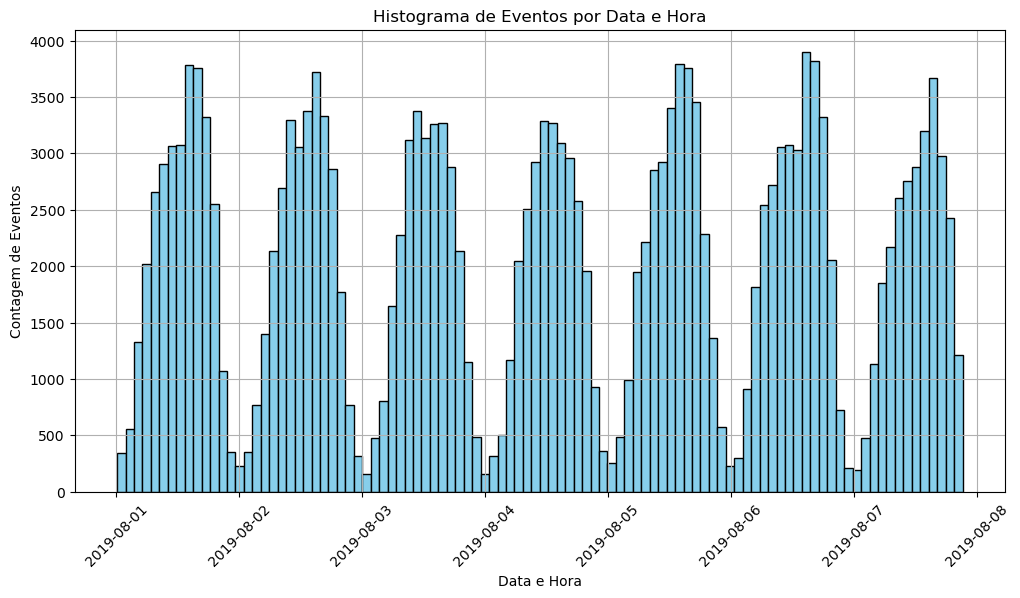

In [671]:
# reimprimindo histograma de eventos por data/hora
plt.figure(figsize=(12, 6))
logs_filtered_filtered['date_time'].hist(bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Data e Hora')
plt.ylabel('Contagem de Eventos')
plt.title('Histograma de Eventos por Data e Hora')
plt.xticks(rotation=45)
plt.show()

#### 2.5.3.Anotações

**Intervalo de tempo dos dados filtrados:**  

De 01/08/2019 a 07/08/2019.

### **2.6.Balanço dos dados filtrados**

#### 2.6.1.Processamento

In [672]:
# conferindo número de eventos DADOS BRUTOS
logs_br.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   user_id    243713 non-null  int64         
 2   group      243713 non-null  int64         
 3   date_time  243713 non-null  datetime64[ns]
 4   date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [673]:
# conferindo número de usuários DADOS BRUTOS
logs_br['user_id'].nunique()

7551

In [674]:
# conferindo número de eventos DADOS FILTRADOS (excluídos valores atípicos)
logs_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209333 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      209333 non-null  object        
 1   user_id    209333 non-null  int64         
 2   group      209333 non-null  int64         
 3   date_time  209333 non-null  datetime64[ns]
 4   date       209333 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.6+ MB


In [675]:
# conferindo número de usuários DADOS FILTRADOS (excluídos valores atípicos)
logs_filtered['user_id'].nunique()

7475

In [676]:
# conferindo número de eventos DADOS FILTRADOS 2 (excluído período com dados incompletos)
logs_filtered_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206615 entries, 2828 to 244125
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      206615 non-null  object        
 1   user_id    206615 non-null  int64         
 2   group      206615 non-null  int64         
 3   date_time  206615 non-null  datetime64[ns]
 4   date       206615 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.5+ MB


In [677]:
# conferindo número de usuários DADOS FILTRADOS 2 (excluído período com dados incompletos)
logs_filtered_filtered['user_id'].nunique()

7458

In [678]:
# conferindo se há usuários de todos os 3 grupos
logs_filtered_filtered['group'].value_counts()

group
248    70908
247    68295
246    67412
Name: count, dtype: int64

In [679]:
# renomeando DataFrame filtrado
logs = logs_filtered_filtered

#### 2.6.2.Anotações

**Eventos:**  

**Dados brutos:** 243713 entradas  
**Dados filtrados:** 206615 entradas  
**Dados descartados:** 37098 entradas - 15.22% dos dados brutos.  
  
    
**Usuários:**  

**Dados brutos:** 7551 usuários  
**Dados filtrados:** 7458 usuários  
**Dados descartados:** 93 usuários - 1.23% dos usuários totais.  

## 3.Funil de eventos

### 3.1.Eventos

#### 3.1.1.Processamento

In [680]:
# verificando eventos unívocos e frequência de ocorrência de cada um
events_freq = logs['event'].value_counts()
events_freq.sort_values(ascending=False)

event
MainScreenAppear           113264
OffersScreenAppear          40956
CartScreenAppear            29250
PaymentScreenSuccessful     22164
Tutorial                      981
Name: count, dtype: int64

In [681]:
# verificando o número de usuários que executaram cada ação
users_per_event = logs.groupby('event')['user_id'].nunique()
users_per_event.sort_values(ascending=False)

event
MainScreenAppear           7344
OffersScreenAppear         4517
CartScreenAppear           3658
PaymentScreenSuccessful    3463
Tutorial                    824
Name: user_id, dtype: int64

In [682]:
# contando o total de usuários
total_users = logs['user_id'].nunique()

# verificando a proporção de usuários que executaram cada ação pelo menos uma vez
logs_prop = users_per_event/total_users
logs_prop.sort_values(ascending=False)

event
MainScreenAppear           0.984714
OffersScreenAppear         0.605658
CartScreenAppear           0.490480
PaymentScreenSuccessful    0.464334
Tutorial                   0.110485
Name: user_id, dtype: float64

#### 3.1.2.Anotações

- Eventos unívocos e frequência de ocorrência:  
  
Main Screen Appear - 113264  
Offers Screen Appear  - 40956  
Cart Screen Appear - 29250  
Payment Screen Successful - 22164  
Tutorial - 981  
  
- Quantidade de usuários que executaram cada ação:  
  
Main Screen Appear - 7344  
Offers Screen Appear  - 4517  
Cart Screen Appear - 3658  
Payment Screen Successful - 3463  
Tutorial - 824  
  
- Proporção de usuários que executaram cada ação pelo menos uma vez:  
  
Main Screen Appear - 0.98%  
Offers Screen Appear  - 0.61%  
Cart Screen Appear - 0.49%  
Payment Screen Successful - 0.46%  
Tutorial - 0.11%  

Ordem de ocorrência dos eventos: 
   
Supõe-se que a ordem de aparição das telas seja  
(A) Main Screen Appear > (B) Offers Screen Appear > (C) Cart Screen Appear > (D) Payment Screen Successful  
(E) Tutorial pode ser acessada em diferentes momentos do processo.

### 3.2.Funil

#### 3.2.1.Processamento

In [683]:
# salvando quantidade de usuários por etapa
users_event_A = users_per_event['MainScreenAppear']
users_event_B = users_per_event['OffersScreenAppear']
users_event_C = users_per_event['CartScreenAppear']
users_event_D = users_per_event['PaymentScreenSuccessful']
users_event_E = users_per_event['Tutorial']

In [684]:
# calculando parcela de usuários que passam da etapa A para B
convertion_A_B = users_event_B/users_event_A
convertion_A_B

0.6150599128540305

In [685]:
# calculando parcela de usuários que passam da etapa B para C
convertion_B_C = users_event_C/users_event_B
convertion_B_C

0.8098295328758025

In [686]:
# calculando parcela de usuários que passam da etapa C para D
convertion_C_D = users_event_D/users_event_C
convertion_C_D

0.9466921815199563

In [687]:
# calculando parcela de usuários que passam por todas as etapas, de A a D
convertion_A_D = users_event_D/users_event_A
convertion_A_D

0.471541394335512

#### 3.2.2.Gráfico

c:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


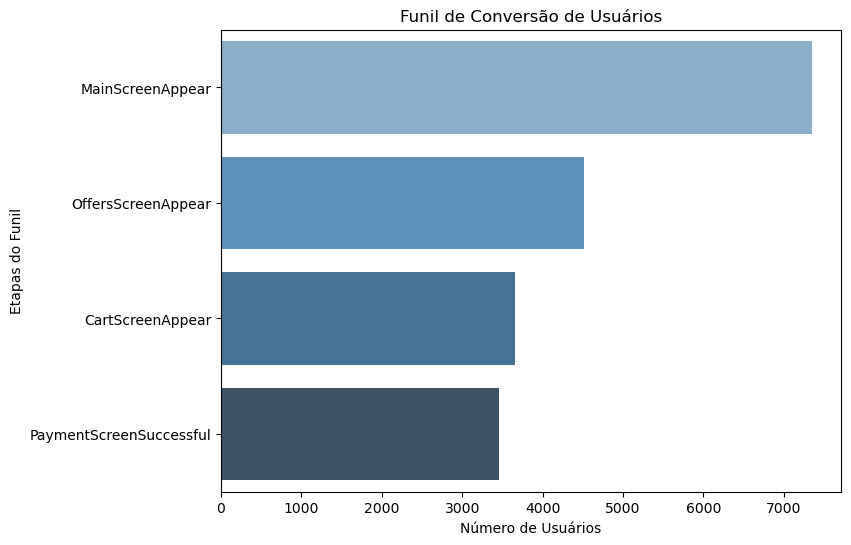

In [688]:
# Dados das conversões em cada etapa
etapas = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
usuarios = [users_event_A, users_event_B, users_event_C, users_event_D]

# Definindo o tamanho da figura
plt.figure(figsize=(8, 6))

# Criando o gráfico de funil
sns.barplot(x=usuarios, y=etapas, palette='Blues_d')

# Adicionando rótulos aos eixos e título
plt.title('Funil de Conversão de Usuários')
plt.xlabel('Número de Usuários')
plt.ylabel('Etapas do Funil')

# Exibir a visualização
plt.show()

#### 3.2.3.Anotações

**Taxa de conversão entre etapas:**  

(A) Main Screen Appear > (B) Offers Screen Appear : 61%  
(B) Offers Screen Appear > (C) Cart Screen Appear : 81%  
(C) Cart Screen Appear > (D) Payment Screen Successful : 95%    
  
(A) Main Screen Appear > (D) Payment Screen Successful : 47%

A etapa com menor conversão de usuários é a transição entre a 'Main Screen' e 'Offers Screen'.  
Uma vez que o usuário é apresentado à tela de ofertas, a conversão para a tela 'Cart Screen' é de 81%, dos quais 95% chegam à tela de 'Payment Successful'.  
  
47% dos usuários que acessam a etapa A 'Main Screen', chegam à etapa final D 'Payment Successful'.

## 4.Teste A/A/B

### 4.1.Grupos

#### 4.1.1.Preparando dados

In [689]:
# agrupando dados por grupo
group_246 = logs[logs['group'] == 246]
group_247 = logs[logs['group'] == 247]
group_248 = logs[logs['group'] == 248]

In [690]:
# contando a quantidade de usuários por grupo
num_users_246 = group_246['user_id'].nunique()
num_users_247 = group_247['user_id'].nunique()
num_users_248 = group_248['user_id'].nunique()

print(num_users_246)
print(num_users_247)
print(num_users_248)

2456
2491
2511


In [691]:
# contando a quantidade de eventos por usuário em cada grupo
events_246 = group_246.groupby('user_id').size()
events_247 = group_247.groupby('user_id').size()
events_248 = group_248.groupby('user_id').size()

Verificando se cada usuário está vinculado a um único grupo.

In [692]:
# agrupando por 'user_id' e contando o número de grupos distintos para cada um
group_count = logs.groupby('user_id')['group'].nunique()

# verificando se todos os 'user_id' têm apenas um grupo associado
unique_group_per_user = group_count.max() == 1

print("Cada user_id está vinculado a um único group:", unique_group_per_user)

Cada user_id está vinculado a um único group: True


Nível de significância estatística para testes

In [693]:
# definindo nível de significância estatística
alpha = 0.05

### **4.2.Grupos de controle**

#### 4.2.1.Quantidade de usuários por grupo

Calculando se há diferença de mais de 1% na **quantidade de usuários** por grupo.

In [694]:
# calculando a diferença percentual
percent_diff = abs(num_users_246 - num_users_247) / ((num_users_246 + num_users_247) / 2) * 100

# verificando se a diferença é maior que 1%
if percent_diff > 1:
    print(f"A diferença entre os grupos é de {percent_diff:.2f}%, maior que 1%.")
else:
    print(f"A diferença entre os grupos é de {percent_diff:.2f}%, menor ou igual a 1%.")

A diferença entre os grupos é de 1.41%, maior que 1%.


#### 4.2.2.Média de eventos por usuário

Analisando se há diferença entre a **média de eventos por usuário** entre os grupos.

In [695]:
# executando o t-test
results = ttest_ind(events_246, events_247, equal_var=False)

# imprimindo o valor-p
print('valor-p: ', results.pvalue)

# verificando se o valor-p é menor que o nível de significância
if results.pvalue < alpha:
    print("Rejeitando a hipótese nula: há uma diferença significativa entre as médias dos grupos.")
else:
    print("Falha ao rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.")

valor-p:  0.9680167483493458
Falha ao rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.


#### 4.2.3.Igualdade de proporções de usuários por evento

In [696]:
# definindo função para salvar quantidade de usuários realizando cada ação e calcular proporção por grupo
def process_groups(group_246, group_247, event, alpha=0.05):
    
    # Passo 1: Salvando o total de usuários em cada grupo
    total_246 = group_246['user_id'].nunique()
    total_247 = group_247['user_id'].nunique()

    # Passo 2: Salvando o número de usuários que realizaram a ação em cada grupo
    users_246_event = group_246[group_246['event'] == event]['user_id'].nunique()
    users_247_event = group_247[group_247['event'] == event]['user_id'].nunique()

    # Passo 3: Calculando a proporção de usuários que realizaram a ação em cada grupo
    prop_246 = users_246_event / total_246
    prop_247 = users_247_event / total_247
    
    # Passo 4: Realizando o z-test para comparar as proporções
    count = [users_246_event, users_247_event]  
    nobs = [total_246, total_247]  
    z_stat, p_value = proportions_ztest(count, nobs)

    # Verificando se o valor-p é menor que o nível de significância
    if p_value < alpha:
        conclusion = "Rejeitando a hipótese nula: há uma diferença significativa entre as proporções dos grupos."
    else:
        conclusion = "Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes."

    return {
        'total_246': total_246,
        'total_247': total_247,
        'users_246_event': users_246_event,
        'users_247_event': users_247_event,
        'prop_246': prop_246,
        'prop_247': prop_247,
        'z_stat': z_stat,
        'p_value': p_value,
        'conclusion': conclusion
}

In [697]:
# organizando eventos por odem de frequência
logs['event'].value_counts().sort_values(ascending=False)

event
MainScreenAppear           113264
OffersScreenAppear          40956
CartScreenAppear            29250
PaymentScreenSuccessful     22164
Tutorial                      981
Name: count, dtype: int64

In [698]:
# aplicando a função para o evento 'Main Screen Appear'
results_MainScreenAppear = process_groups(group_246, group_247, 'MainScreenAppear')
results_MainScreenAppear

{'total_246': 2456,
 'total_247': 2491,
 'users_246_event': 2423,
 'users_247_event': 2454,
 'prop_246': 0.9865635179153095,
 'prop_247': 0.9851465274989963,
 'z_stat': 0.4219038760933072,
 'p_value': 0.6730951807208486,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes.'}

In [699]:
# aplicando a função para o evento 'Offers Screen Appear'
results_OffersScreenAppear = process_groups(group_246, group_247, 'OffersScreenAppear')
results_OffersScreenAppear

{'total_246': 2456,
 'total_247': 2491,
 'users_246_event': 1514,
 'users_247_event': 1498,
 'prop_246': 0.6164495114006515,
 'prop_247': 0.6013649136892815,
 'z_stat': 1.0870205746026653,
 'p_value': 0.27702771700769824,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes.'}

In [700]:
# aplicando a função para o evento 'Cart Screen Appear'
results_CartScreenAppear = process_groups(group_246, group_247, 'CartScreenAppear')
results_CartScreenAppear

{'total_246': 2456,
 'total_247': 2491,
 'users_246_event': 1238,
 'users_247_event': 1216,
 'prop_246': 0.504071661237785,
 'prop_247': 0.4881573665194701,
 'z_stat': 1.119337305554838,
 'p_value': 0.26299626637167794,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes.'}

In [701]:
# aplicando a função para o evento 'Payment Screen Successful'
results_PaymentScreenSuccessful = process_groups(group_246, group_247, 'PaymentScreenSuccessful')
results_PaymentScreenSuccessful

{'total_246': 2456,
 'total_247': 2491,
 'users_246_event': 1172,
 'users_247_event': 1136,
 'prop_246': 0.4771986970684039,
 'prop_247': 0.4560417503010839,
 'z_stat': 1.4913768456314167,
 'p_value': 0.13586258367273996,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes.'}

In [702]:
# aplicando a função para o evento 'Tutorial'
results_Tutorial = process_groups(group_246, group_247, 'Tutorial')
results_Tutorial

{'total_246': 2456,
 'total_247': 2491,
 'users_246_event': 269,
 'users_247_event': 279,
 'prop_246': 0.10952768729641693,
 'prop_247': 0.11200321156162184,
 'z_stat': -0.2773779458467628,
 'p_value': 0.7814899141660463,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes.'}

#### 4.2.4.Anotações

1. Quantidade de usuários por grupo:  

A diferença entre os grupos é de 1.41%, maior que 1%.  

2. Teste de hipótese para avaliar se há diferença entre a **média de eventos por usuário** entre os grupos:  

Valor p: 0.97  
Não há evidência estatisticamente significativa para rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.

3. Foi verificado que todos os usuários estão vinculados a apenas um grupo.

4. Igualde de proporções:  

Para todos os 5 eventos, os testes concluíram que não há diferença estatísticamente significativa entre as proporções de usuários por evento nos dois grupos de controle 246 e 247.

#### 4.2.5.Conclusões teste A/A

Embora haja diferença de mais de 1% na quantidade de usuários dos dois grupos de controle (1.41%), os testes de diferenças de médias e proporções indica que não há diferença estatisticamente significativa entre os dois grupos. Portanto, pode-se afirmar que os grupos foram divididos adequadamente.

### **4.3.Teste A/B 246/248**

#### 4.3.1.Quantidade de usuários por grupo

Calculando se há diferença de mais de 1% na **quantidade de usuários** por grupo.

In [703]:
# calculando a diferença percentual
percent_diff_a_b_1 = abs(num_users_246 - num_users_248) / ((num_users_246 + num_users_248) / 2) * 100

# verificando se a diferença é maior que 1%
if percent_diff_a_b_1 > 1:
    print(f"A diferença entre os grupos é de {percent_diff_a_b_1:.2f}%, maior que 1%.")
else:
    print(f"A diferença entre os grupos é de {percent_diff_a_b_1:.2f}%, menor ou igual a 1%.")

A diferença entre os grupos é de 2.21%, maior que 1%.


#### 4.3.2.Média de eventos por usuário

Analisando se há diferença entre a **média de eventos por usuário** entre os grupos.

In [704]:
# definindo nível de significância estatística
alpha = 0.05

# executando o t-test
results_1 = ttest_ind(events_246, events_248, equal_var=False)

# imprimindo o valor-p
print('valor-p: ', results_1.pvalue)

# verificando se o valor-p é menor que o nível de significância
if results_1.pvalue < alpha:
    print("Rejeitando a hipótese nula: há uma diferença significativa entre as médias dos grupos.")
else:
    print("Falha ao rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.")

valor-p:  0.31540320523583665
Falha ao rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.


#### 4.3.3.Igualdade de proporções de usuários por evento

In [705]:
# definindo função para salvar quantidade de usuários realizando cada ação e calcular proporção por grupo
def process_groups_a_b_1(group_246, group_248, event):
    
    # passo 1: salvando o total de usuários em cada grupo
    total_246 = group_246['user_id'].nunique()
    total_248 = group_248['user_id'].nunique()

    # passo 2: salvando o número de usuários que realizaram a ação em cada grupo
    users_246_event = group_246[group_246['event'] == event]['user_id'].nunique()
    users_248_event = group_248[group_248['event'] == event]['user_id'].nunique()

    # passo 3: calculando a proporção de usuários que realizaram a ação em cada grupo
    prop_246 = users_246_event / total_246
    prop_248 = users_248_event / total_248
    
    # Passo 4: Realizando o z-test para comparar as proporções
    count = [users_246_event, users_248_event]  
    nobs = [total_246, total_248]  
    z_stat, p_value = proportions_ztest(count, nobs)

    # Verificando se o valor-p é menor que o nível de significância
    if p_value < alpha:
        conclusion = "Rejeitando a hipótese nula: há uma diferença significativa entre as proporções dos grupos."
    else:
        conclusion = "Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes."

    return {
        'total_246': total_246,
        'total_248': total_248,
        'users_246_event': users_246_event,
        'users_248_event': users_248_event,
        'prop_246': prop_246,
        'prop_248': prop_248,
        'z_stat': z_stat,
        'p_value': p_value,
        'conclusion': conclusion
}

In [706]:
# aplicando a função para o evento 'Main Screen Appear'
results_MainScreenAppear_a_b_1 = process_groups_a_b_1(group_246, group_248, 'MainScreenAppear')
results_MainScreenAppear_a_b_1

{'total_246': 2456,
 'total_248': 2511,
 'users_246_event': 2423,
 'users_248_event': 2467,
 'prop_246': 0.9865635179153095,
 'prop_248': 0.9824771007566706,
 'z_stat': 1.1655409178548093,
 'p_value': 0.24380010740478963,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes.'}

In [707]:
# aplicando a função para o evento 'Offers Screen Appear'
results_OffersScreenAppear_a_b_1 = process_groups_a_b_1(group_246, group_248, 'OffersScreenAppear')
results_OffersScreenAppear_a_b_1

{'total_246': 2456,
 'total_248': 2511,
 'users_246_event': 1514,
 'users_248_event': 1505,
 'prop_246': 0.6164495114006515,
 'prop_248': 0.599362803663879,
 'z_stat': 1.233153034101185,
 'p_value': 0.21751867407994285,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes.'}

In [708]:
# aplicando a função para o evento 'Cart Screen Appear'
results_CartScreenAppear_a_b_1 = process_groups_a_b_1(group_246, group_248, 'CartScreenAppear')
results_CartScreenAppear_a_b_1

{'total_246': 2456,
 'total_248': 2511,
 'users_246_event': 1238,
 'users_248_event': 1204,
 'prop_246': 0.504071661237785,
 'prop_248': 0.47949024293110315,
 'z_stat': 1.7325590041338186,
 'p_value': 0.08317408116828569,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes.'}

In [709]:
# aplicando a função para o evento 'Payment Screen Successful'
results_PaymentScreenSuccessful_a_b_1 = process_groups_a_b_1(group_246, group_248, 'PaymentScreenSuccessful')
results_PaymentScreenSuccessful_a_b_1

{'total_246': 2456,
 'total_248': 2511,
 'users_246_event': 1172,
 'users_248_event': 1155,
 'prop_246': 0.4771986970684039,
 'prop_248': 0.45997610513739545,
 'z_stat': 1.2161383227995284,
 'p_value': 0.2239322340682175,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes.'}

In [710]:
# aplicando a função para o evento 'Tutorial'
results_Tutorial_a_b_1 = process_groups_a_b_1(group_246, group_248, 'Tutorial')
results_Tutorial_a_b_1

{'total_246': 2456,
 'total_248': 2511,
 'users_246_event': 269,
 'users_248_event': 276,
 'prop_246': 0.10952768729641693,
 'prop_248': 0.10991636798088411,
 'z_stat': -0.04381975612267146,
 'p_value': 0.965048079100338,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes.'}

#### 4.3.4.Anotações

1. Quantidade de usuários por grupo:  

A diferença entre os grupos é de 2.21%, maior que 1%.  

2. Teste de hipótese para avaliar se há diferença entre a **média de eventos por usuário** entre os grupos:  

Valor p: 0.31  
Não há evidência estatisticamente significativa para rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.

3. Igualde de proporções:  

Para todos os 5 eventos, os testes concluíram que não há diferença estatisticamente significativa entre as proporções de usuários por evento nos dois grupos 246 e 248.

### **4.4.Teste A/B 247/248**

#### 4.3.1.Quantidade de usuários por grupo

Calculando se há diferença de mais de 1% na **quantidade de usuários** por grupo.

In [711]:
# calculando a diferença percentual
percent_diff_a_b_2 = abs(num_users_247 - num_users_248) / ((num_users_247 + num_users_248) / 2) * 100

# verificando se a diferença é maior que 1%
if percent_diff_a_b_2 > 1:
    print(f"A diferença entre os grupos é de {percent_diff_a_b_2:.2f}%, maior que 1%.")
else:
    print(f"A diferença entre os grupos é de {percent_diff_a_b_2:.2f}%, menor ou igual a 1%.")

A diferença entre os grupos é de 0.80%, menor ou igual a 1%.


#### 4.3.2.Média de eventos por usuário

Analisando se há diferença entre a **média de eventos por usuário** entre os grupos.

In [712]:
# definindo nível de significância estatística
alpha = 0.05

# executando o t-test
results = ttest_ind(events_247, events_248, equal_var=False)

# imprimindo o valor-p
print('valor-p: ', results.pvalue)

# verificando se o valor-p é menor que o nível de significância
if results.pvalue < alpha:
    print("Rejeitando a hipótese nula: há uma diferença significativa entre as médias dos grupos.")
else:
    print("Falha ao rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.")

valor-p:  0.2945121683330858
Falha ao rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.


#### 4.3.3.Igualdade de proporções de usuários por evento

In [713]:
# definindo função para salvar quantidade de usuários realizando cada ação e calcular proporção por grupo
def process_groups_a_b_2(group_247, group_248, event):
    
    # passo 1: salvando o total de usuários em cada grupo
    total_247 = group_247['user_id'].nunique()
    total_248 = group_248['user_id'].nunique()

    # passo 2: salvando o número de usuários que realizaram a ação em cada grupo
    users_247_event = group_247[group_247['event'] == event]['user_id'].nunique()
    users_248_event = group_248[group_248['event'] == event]['user_id'].nunique()

    # passo 3: calculando a proporção de usuários que realizaram a ação em cada grupo
    prop_247 = users_247_event / total_247
    prop_248 = users_248_event / total_248
    
    # passo 4: Realizando o z-test para comparar as proporções
    count = [users_247_event, users_248_event]  
    nobs = [total_247, total_248]  
    z_stat, p_value = proportions_ztest(count, nobs)
    
    # verificando se o valor-p é menor que o nível de significância
    if p_value < alpha:
        conclusion = "Rejeitando a hipótese nula: há uma diferença significativa entre as médias dos grupos."
    else:
        conclusion = "Falha ao rejeitar a hipótese nula: não há motivo para considerar as médias diferentes."

    return {
        'total_247': total_247,
        'total_248': total_248,
        'users_247_event': users_247_event,
        'users_248_event': users_248_event,
        'prop_247': prop_247,
        'prop_248': prop_248,
        'z_stat': z_stat,
        'p_value': p_value,
        'conclusion': conclusion
}

In [714]:
# aplicando a função para o evento 'Main Screen Appear'
results_MainScreenAppear_a_b_2 = process_groups_a_b_2(group_247, group_248, 'MainScreenAppear')
results_MainScreenAppear_a_b_2

{'total_247': 2491,
 'total_248': 2511,
 'users_247_event': 2454,
 'users_248_event': 2467,
 'prop_247': 0.9851465274989963,
 'prop_248': 0.9824771007566706,
 'z_stat': 0.7478782080620041,
 'p_value': 0.45453362307563017,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.'}

In [715]:
# aplicando a função para o evento 'Offers Screen Appear'
results_OffersScreenAppear_a_b_2 = process_groups_a_b_2(group_247, group_248, 'OffersScreenAppear')
results_OffersScreenAppear_a_b_2

{'total_247': 2491,
 'total_248': 2511,
 'users_247_event': 1498,
 'users_248_event': 1505,
 'prop_247': 0.6013649136892815,
 'prop_248': 0.599362803663879,
 'z_stat': 0.14453929796491002,
 'p_value': 0.885074626949582,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.'}

In [716]:
# aplicando a função para o evento 'Cart Screen Appear'
results_CartScreenAppear_a_b_2 = process_groups_a_b_2(group_247, group_248, 'CartScreenAppear')
results_CartScreenAppear_a_b_2

{'total_247': 2491,
 'total_248': 2511,
 'users_247_event': 1216,
 'users_248_event': 1204,
 'prop_247': 0.4881573665194701,
 'prop_248': 0.47949024293110315,
 'z_stat': 0.613297580362309,
 'p_value': 0.5396795929970241,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.'}

In [717]:
# aplicando a função para o evento 'Payment Screen Successful'
results_PaymentScreenSuccessful_a_b_2 = process_groups_a_b_2(group_247, group_248, 'PaymentScreenSuccessful')
results_PaymentScreenSuccessful_a_b_2

{'total_247': 2491,
 'total_248': 2511,
 'users_247_event': 1136,
 'users_248_event': 1155,
 'prop_247': 0.4560417503010839,
 'prop_248': 0.45997610513739545,
 'z_stat': -0.2792404225137876,
 'p_value': 0.7800603242138476,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.'}

In [718]:
# aplicando a função para o evento 'Tutorial'
results_Tutorial_a_b_2 = process_groups_a_b_2(group_247, group_248, 'Tutorial')
results_Tutorial_a_b_2

{'total_247': 2491,
 'total_248': 2511,
 'users_247_event': 279,
 'users_248_event': 276,
 'prop_247': 0.11200321156162184,
 'prop_248': 0.10991636798088411,
 'z_stat': 0.23495890270667819,
 'p_value': 0.8142406312184222,
 'conclusion': 'Falha ao rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.'}

#### 4.3.4.Anotações

1. Quantidade de usuários por grupo:  

A diferença entre os grupos é de 0.80%, menor que 1%.

2. Teste de hipótese para avaliar se há diferença entre a **média de eventos por usuário** entre os grupos:  

Valor p: 0.29  
Não há evidência estatisticamente significativa para rejeitar a hipótese nula: não há motivo para considerar as médias diferentes.


3. Igualde de proporções:  

Para todos os 5 eventos, os testes concluíram que não há diferença estatísticamente significativa entre as proporções de usuários por evento nos dois grupos 247 e 248.

### **4.5.Conclusões Teste A/B**

Os testes mostram que, considerando um nível de significância de 0.05, não há diferença estatisticamente significante entre as proporções dos grupos. Portanto, o teste A/A/B indica que a alteração do layout do aplicativo não afeta significativamente o comportamento do usuário.  
Deve-se observar que a divisão dos grupos pode ser questionada. Entre os grupos de controle há uma diferença de 1,41% na quantidade de usuários, enquanto entre o grupo 246 e 248 há uma diferença de 2,21%, apenas entre os grupos 247 e 248 a diferença está dentro do esperado, 0,8%.